In [1]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils

from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K

import numpy as np


In [2]:
import cv2
import os
from matplotlib import pyplot as plt

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [3]:
benign = load_images('lung_image_sets/lung_n')
mal_aca = load_images('lung_image_sets/lung_aca')
mal_scc = load_images('lung_image_sets/lung_scc')

In [4]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

print(f"Images shape: {benign[0].shape}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.
Images shape: (80, 80, 3).


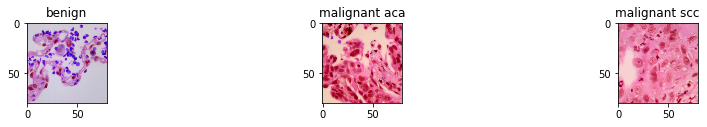

In [5]:
indices = [0, 40, 2300]

plt.figure(1, figsize=(15,5))
plt.grid(None)

for n, idx in enumerate(indices):
    plt.subplot(n+1, 3, 1) 
    plt.imshow(benign[idx])
    plt.title('benign')
    plt.subplot(n+1, 3, 2) 
    plt.imshow(mal_aca[idx])
    plt.title('malignant aca')
    plt.subplot(n+1, 3, 3) 
    plt.imshow(mal_scc[idx])
    plt.title('malignant scc')

plt.show()


In [6]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [7]:
print(f"Samples shape check: {samples.shape}.")
print(f"Labels shape check: {labels.shape}.")

Samples shape check: (15000, 80, 80, 3).
Labels shape check: (15000,).


In [8]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures

samples = samples.astype('float32') / 255

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [10]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)

print(Y_train[0])
print(f"Y_train shape after one hot encoding: {Y_val.shape}")
print(f"Y_train shape after one hot encoding: {X_val.shape}")

[0. 0. 1.]
Y_train shape after one hot encoding: (1500, 3)
Y_train shape after one hot encoding: (1500, 80, 80, 3)


# **MODEL**

In [11]:
def base_model(input_shape=(80,80,3),classes=3):
    
    inputs = Input(shape=input_shape)

    X = Conv2D(32, 3, 3, activation='relu')(inputs)
    X = MaxPooling2D(pool_size=(2,2))(X)

    X = Conv2D(64, 3, 3, activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(128, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)

    X = Conv2D(256, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)
    
    X = Conv2D(512, 3, 3, activation='relu', padding='same')(X)
    X = MaxPooling2D(pool_size=(2,2), padding='same')(X)
    X = Dropout(0.2)(X)
    
    X = Flatten()(X)
    X = Dense(1024, activation='relu')(X)
    outputs = Dense(classes, activation='softmax')(X)

    model = Model(inputs, outputs)
    
    return model

In [12]:
model = base_model(input_shape=(80,80,3),classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0     

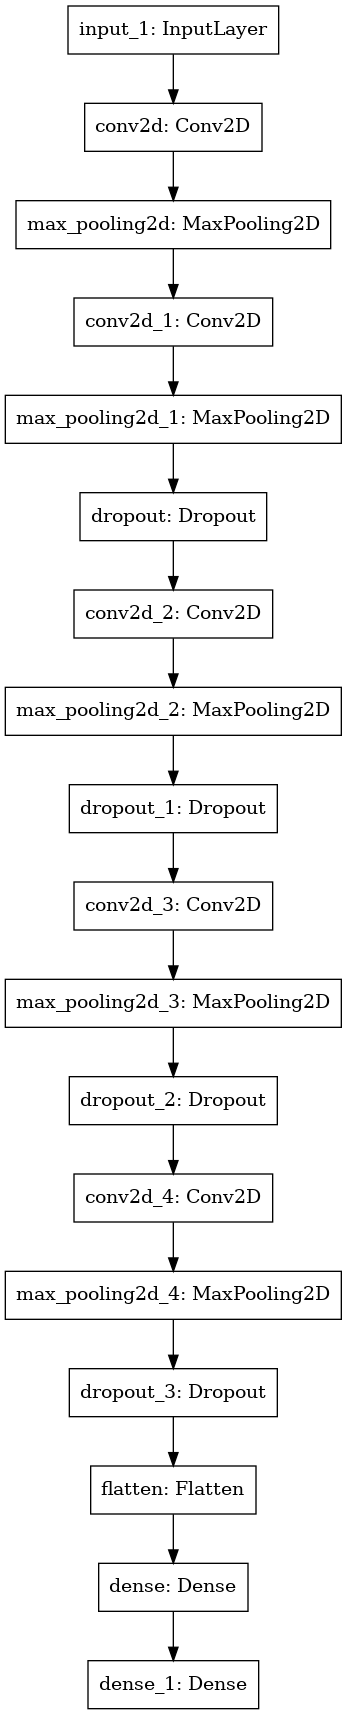

In [13]:
from  tensorflow import keras
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [15]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=25, validation_data=(X_val, Y_val))

Epoch 1/25
188/188 [==============================] - 6s 15ms/step - loss: 0.5191 - accuracy: 0.7385 - val_loss: 0.3434 - val_accuracy: 0.8600
Epoch 2/25
188/188 [==============================] - 2s 11ms/step - loss: 0.3421 - accuracy: 0.8554 - val_loss: 0.2559 - val_accuracy: 0.9120
Epoch 3/25
188/188 [==============================] - 2s 10ms/step - loss: 0.2651 - accuracy: 0.8932 - val_loss: 0.2106 - val_accuracy: 0.9153
Epoch 4/25
188/188 [==============================] - 2s 10ms/step - loss: 0.2371 - accuracy: 0.9052 - val_loss: 0.1928 - val_accuracy: 0.9187
Epoch 5/25
188/188 [==============================] - 2s 11ms/step - loss: 0.2112 - accuracy: 0.9147 - val_loss: 0.1725 - val_accuracy: 0.9353
Epoch 6/25
188/188 [==============================] - 2s 11ms/step - loss: 0.1921 - accuracy: 0.9257 - val_loss: 0.1622 - val_accuracy: 0.9387
Epoch 7/25
188/188 [==============================] - 2s 11ms/step - loss: 0.1922 - accuracy: 0.9229 - val_loss: 0.1673 - val_accuracy: 0.9380

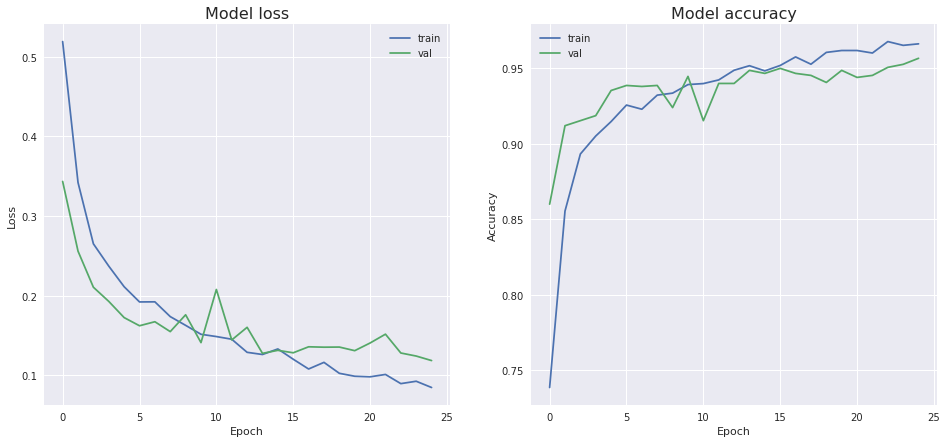

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [18]:
y_pred_test = model.predict(X_test, verbose=1)
y_pred_train = model.predict(X_train, verbose=1)

375/375 [==============================] - 1s 3ms/step


In [19]:
# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

In [20]:
score_test = model.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 0s 5ms/step - loss: 0.1217 - accuracy: 0.9573
Train accuracy: 0.966
Validation accuracy: 0.957
Test accuracy: 0.957


<AxesSubplot:>

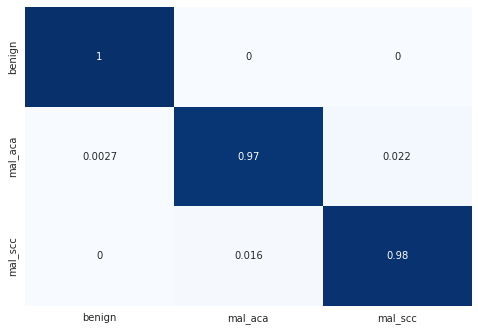

In [21]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)